In [18]:
import getpass
username = getpass.getuser()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/data_preprocessing_code'.format(username))
sys.path.append('/Users/{:}/GitHub/mouse_bandit'.format(username))
import support_functions as sf
% matplotlib inline

In [3]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
#data = data[data['Mouse ID']=='Baby']
data = data[data['Condition']=='80-20']
data.head()

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
106400,0,Baby,01112018_Baby,11.0,11.0,5.0,2.0,-2.0,0.0,1.0,...,0.566,1.544,0.560,0.0,1.0,1.0,1.0,80-20,1.0,13.0
106401,1,Baby,01112018_Baby,12.0,12.0,6.0,1.0,1.0,0.0,1.0,...,0.560,2.506,0.497,0.0,0.0,1.0,1.0,80-20,1.0,13.0
106402,2,Baby,01112018_Baby,13.0,0.0,7.0,2.0,2.0,0.0,0.0,...,0.497,2.526,0.562,0.0,0.0,0.0,0.0,80-20,2.0,53.0
106403,3,Baby,01112018_Baby,14.0,1.0,0.0,3.0,-1.0,1.0,0.0,...,0.562,1.780,0.587,0.0,0.0,0.0,0.0,80-20,2.0,53.0
106404,4,Baby,01112018_Baby,15.0,2.0,0.0,4.0,-2.0,0.0,1.0,...,0.587,4.313,0.382,1.0,1.0,1.0,1.0,80-20,2.0,53.0


Markov process is one in which the future state of the system does not depend on more (history) than the current state

In [4]:
emission_prob = 0.8
transition_prob = 0.02

In [115]:
# function inputs: DATA, EMISSIONPROB, TRANSITION_PROB=0.02
def hmm_pred(data, emmission_prob, transition_prob=0.02, strategy='greedy', n_prev_trials=10):

    # latent state z (0 left, 1 right)
    # action a (0 left, 1 right)
    # reward r (0 no reward, 1 reward)
    # transition_prob = 0.02

    # emission probabilities (observed probabilities of reward)
    p = emission_prob # probability of reward for correct side
    q = 1-p # probability of reward for incorrect side
    s = 1-transition_prob # probability of remaining in same state

    # transition matrix T[i,j] = i->j
    T = np.array([[s, transition_prob],[transition_prob, s]])

    # observation array O
    # O[r,z,a] = Pr(reward=r | state=z, action=a)
    O = np.zeros((2,2,2)) # each component has two conditions 0,1
    # right choice = 0, no reward = 0, right state = 0
    O[:,:,0] = np.array([[1-p, 1-q],[p,q]]) 
    O[:,:,1] = np.array([[1-q, 1-p],[q,p]])

    # split data into train and test sets (ultimately using same seeds as with LR?)

    n_trials = data.shape[0]

    #include past 10 choice and reward values (this is most convenient given the current data structure)
    port_columns = []
    reward_columns = []
    for col in data:
        if '_Port' in col:
            port_columns.append(col)
        elif '_Reward' in col:
            reward_columns.append(col)

    y_predict = np.zeros(n_trials)
    beliefs = np.zeros(n_trials)


    for trial in range(n_trials):
        curr_trial = data.iloc[trial]
        actions = curr_trial[port_columns].values.astype('int')
        rewards = curr_trial[reward_columns].values.astype('int')
        beliefs_curr = np.nan*np.ones((n_prev_trials+1,2))
        beliefs_curr[0] = [0.5,0.5] # initial belief is equal for each port

        for i in range(n_prev_trials):
            #what is this ?
            assert np.allclose(beliefs_curr[i].sum(), 1.0), "Beliefs must sum to one!"

            belief_temp = O[rewards[i],:,actions[i]] * beliefs_curr[i]

            beliefs_curr[i+1] = T.dot(belief_temp) # take dot product of transition matrix and previous belief

            beliefs_curr[i+1] /= beliefs_curr[i+1].sum()
        
        if strategy == 'greedy':
            y_predict[trial] = np.where(beliefs_curr[-1] == beliefs_curr[-1].max())[0][0] 
            
        elif strategy == 'thompson':
            y_predict[trial] = np.random.choice(2,p=[beliefs_curr[-1][0],beliefs_curr[-1][1]])
        
        elif strategy == 'eps_greedy':
            print('need to work on this one')
        
        beliefs[trial] = beliefs_curr[-1][1]
    
    return y_predict, beliefs

In [116]:
y_predict, beliefs = hmm_pred(data, 0.8)

In [117]:
y_predict # greedy default

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [118]:
y_predict_thompson, beliefs = hmm_pred(data, 0.8, strategy='thompson')

In [120]:
beliefs

array([ 0.02650486,  0.02650023,  0.02649823, ...,  0.02649823,
        0.11422885,  0.04999354])

In [14]:
decision = data['Decision'].values
prev_decision = data['1_Port'].values

switch = np.abs(decision-prev_decision)
switch_predict = np.abs(y_predict-prev_decision)


In [12]:
np.abs([y_predict[i]-decisions[i] for i in range(len(beliefs))]).sum()/len(beliefs)

0.13261655222262378

In [19]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(switch_predict,switch,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        91722.0        11737.0
True YES        2941.0         4280.0

F1: 0.368

Accuracy on class 0: 0.89
Accuracy on class 1: 0.59



In [91]:
import sklearn
from sklearn.linear_model import LogisticRegression

metrics1 = sklearn.metrics.precision_recall_fscore_support(decisions, y_predict)

metrics2 = sklearn.metrics.precision_recall_fscore_support(switch, switch_predict)

metrics2


(array([ 0.9689319 ,  0.26721608]),
 array([ 0.88655409,  0.59271569]),
 array([ 0.92591434,  0.36836217]),
 array([103459,   7221]))

In [22]:
'''win stay lose switch'''

prev_outcome = data['1_Reward'].values
wsls_predict = np.abs(1-prev_outcome)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(wsls_predict,switch,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        76032.0        27427.0
True YES        1116.0         6105.0

F1: 0.300

Accuracy on class 0: 0.73
Accuracy on class 1: 0.85



In [85]:
'''Thompson sampling on beliefs'''
thompson = [np.random.choice(2,p=[beliefs[i],(1-beliefs[i])]) for i in range(len(beliefs))]


110680

In [86]:
(thompson==y_predict).sum() # how often do the greedy and thompson hmms agree

100386

In [88]:
precision = np.abs([y_predict[i]-decisions[i] for i in range(len(beliefs))]).sum()/len(beliefs)

In [90]:
precision

0.13261655222262378

In [89]:
np.mean(beliefs) # should be 0.5 if belief switches between ports.

0.49452486185590044

In [83]:
'''TROUBLESHOOTING

# emission probabilities (observed probabilities of reward)
p = emission_prob # probability of reward for correct side
q = 1-p # probability of reward for incorrect side
s = 1-transition_prob # probability of remaining in same state

# transition matrix T[i,j] = i->j
T = np.array([[s, transition_prob],[transition_prob, s]])

# observation array O
# O[r,z,a] = Pr(reward=r | state=z, action=a)
O = np.zeros((2,2,2)) # each component has two conditions 0,1
# right choice = 0, no reward = 0, right state = 0
O[:,:,0] = np.array([[1-p, 1-q],[p,q]]) 
O[:,:,1] = np.array([[1-q, 1-p],[q,p]])

# split data into train and test sets (ultimately using same seeds as with LR?)

n_trials = data.shape[0]

#include past 10 choice and reward values (this is most convenient given the current data structure)
port_columns = []
reward_columns = []
for col in data:
    if '_Port' in col:
        port_columns.append(col)
    elif '_Reward' in col:
        reward_columns.append(col)

y_predict = np.zeros(n_trials)
beliefs = np.zeros(n_trials)

for trial in range(n_trials):
    curr_trial = data.iloc[trial]
    actions = curr_trial[port_columns].values.astype('int')
    rewards = curr_trial[reward_columns].values.astype('int')
    beliefs_curr = np.nan*np.ones((n_prev_trials+1,2))
    beliefs_curr[0] = [0.5,0.5] # initial belief is equal for each port

    for i in range(n_prev_trials):
        assert np.allclose(beliefs_curr[i].sum(), 1.0), "Beliefs must sum to one!"

        belief_temp = O[rewards[i],:,actions[i]] * beliefs_curr[i]

        beliefs_curr[i+1] = T.dot(belief_temp) # take dot product of transition matrix and previous belief

        beliefs_curr[i+1] /= beliefs_curr[i+1].sum()

    y_predict[trial] = np.where(beliefs_curr[-1] == beliefs_curr[-1].max())[0][0] #greedy model
    beliefs[trial] = beliefs_curr[-1][0]
'''

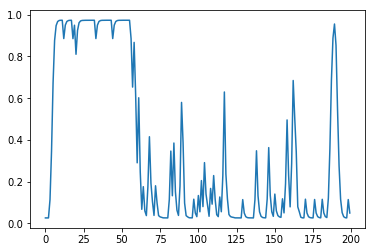

In [122]:
plt.plot(beliefs[0:200])